# Least Angle Regression

Least angle regression (LAR) uses a similar strategy as the forward stepwise regression does, but only enters as much of a predictor as it deserves. This algorithm works as follows:

   * It identifies the variable most correlated with the response.
   * Instead of fitting this variable completely, it moves the coefficient of the most correlated variable toward its least squares value.
   * When another variable produces equal correlation with the residual, this new variable enters the active set.
   * The coefficients in the active set are moved together in a way that keeps their correlations tied and decreasing.
   * This continues until all the variables are in the model.
   
The pseudo-code of LAR is illustrated as follows:

   * Initialization
       * First, we need to standarize all the predictors $\mathbf{X}$ to have a zero mean and unit variance, and set all the initial coefficients to zero $\beta_1 = \beta_2 = \cdots = \beta_p = 0$. The initial residual is $r = y - \bar y$
       * Find the feature $j$ that has the highest absolute correlation with the residue $r$
       $$j = \underset{j}{\text{argmax }} |\mathbf{X}^T r|$$
       * Add $j$ to the active set $A$

   * For every step $k$
       * Move $\beta[A]$ in the least-angle direction of:
       $$\delta_k = \left(\mathbf{X}[A_k]^\top\mathbf{X}[A_k]\right)^{-1}\mathbf{X}[A_k]^\top r$$
       
       until some other feature $\mathbf{X}_i$ has as much correlation with the $k$ residual as does $\mathbf{X}[A]$ ($\star$).
       
       The coefficient profile evolves as:
       $$\beta[A_k](\alpha) = \beta[A_k] + \alpha \delta_k, 0\leq\alpha\leq 1$$

       The only unknown in these two equations is the $\alpha$. 
       
       It is actually possible to iterate through all possible values of alpha and find one that satisfy the above condition ($\star$). However, there is a more efficient way to find the $\alpha$: LAR look-ahead (Exercise 3.25). In this method, we compute $\alpha$ for features not in the active set $b$, and select the feature that produces minimum angle (largest correlation) with the residue. For features not in the active set, $\alpha$ can be computed as follows:
       
       $$\begin{aligned}
       \alpha^{-} &= \frac{x_b^\top r_k-x_a^\top r_k}{x^\top_b X[A_k]\delta_k - x^\top_a X[A_k]\delta_k}, \text{  or}\\
       \alpha^{+} &= \frac{x_b^\top r_k+x_a^\top r_k}{x^\top_b X[A_k]\delta_k + x^\top_a X[A_k]\delta_k}
       \end{aligned}$$
       
       The next variable that will be added to the active set $A_k$ is $b$ with the minimum $\alpha$.
       
**NOTE**: check the [solution manual](https://waxworksmath.com/Authors/G_M/Hastie/WriteUp/Weatherwax_Epstein_Hastie_Solution_Manual.pdf) by Weatherwax to see the details on how to compute $\alpha$.

### Python Implementation

We use *Prostate Cancer* data to test our implementation of LAR-modified Lasso algorithm. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml_datasets.esl import ProstateCancer
from sklearn import preprocessing
from sklearn import datasets
from esl.chapter03 import Lasso

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(df_x[train_test=='T'].values)
x_test = scaler.transform(df_x[train_test=='F'].values)

y_train_temp = df_y[train_test=='T'].copy().values
y_train = y_train_temp - np.mean(y_train_temp)

y_test_temp = df_y[train_test=='F'].copy().values
y_test = y_test_temp  - np.mean(y_train_temp)

Next, we build the `Lar` class based on the pseudo-code.

This class contains one method:

   * `fit`: to fit the model using the LAR algorithm. Here, we'll obtain the path of $\hat\beta_{lar}$.

The following is the complete `Lar` class:

In [4]:
class Lar:
    def fit(self, X, y):
        n, p = X.shape
        beta = np.zeros(p)

        r = y.copy()
        corr = X.T @ r
        best_feat = np.argmax(np.abs(corr))
        A = [best_feat]
        beta_path = np.zeros((p, 1))

        while True: 
            d = np.zeros(p)
            d[A] = np.linalg.inv(X[:, A].T @ X[:, A]) @ X[:, A].T @ r
            alpha = 1.0
            for j in range(p):
                if j not in A:
                    alpha_temp = dict()
                    alpha_temp['+'] = (corr[j]  - corr[best_feat]) / (X[:, j].T @ X[:, A] @ d[A] - X[:, best_feat].T @ X[:, A] @ d[A])
                    alpha_temp['-'] = (corr[j]  + corr[best_feat]) / (X[:, j].T @ X[:, A] @ d[A] + X[:, best_feat].T @ X[:, A] @ d[A])

                    for key in alpha_temp.keys():
                        if alpha_temp[key] <= 0.0:
                            alpha_temp[key] = np.inf

                        if alpha_temp[key] <= alpha:
                            alpha = alpha_temp[key]
                            best_feat_temp = j

            beta = beta + alpha * d  
            beta_path = np.concatenate((beta_path, beta.reshape(-1, 1)), axis=1)

            if alpha == 1.0:
                break

            A.append(best_feat_temp)
            best_feat = best_feat_temp

            r = r - alpha * (X @ d)
            corr = X.T @ r
            
        return A, beta_path

Now, we fit our data with both `lasso` and `lar` algorithm for comparison.

In [5]:
lar = Lar()
_, beta_path_lar = lar.fit(x_train, y_train)

lasso = Lasso()
_, beta_path_lasso = lasso.fit(x_train, y_train)

Next, we plot the profiles of both the `lar` and `lasso` coefficients as the tuning parameter $t$ is varied.

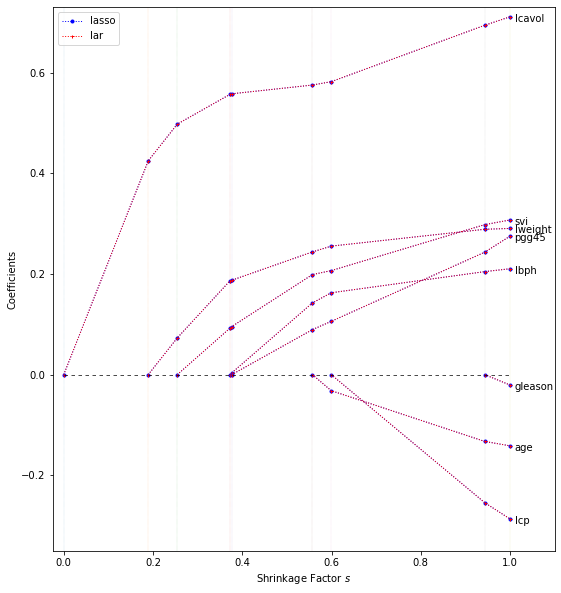

In [6]:
x_lar = np.sum(np.abs(beta_path_lar.T), axis=1)
x_lar /= x_lar[-1]

x_lasso = np.sum(np.abs(beta_path_lasso.T), axis=1)
x_lasso /= x_lasso[-1]

column_names = prostate_cancer.meta[:-1]
plt.figure(figsize=(9, 10))
plt.xlim([-0.025, 1.1])
plt.ylim([-0.35, 0.73])
yy = np.linspace(-0.35, 0.73)
xx = np.linspace(-0.3, 9.5, len(x_lar))

for i in range(x_train.shape[1]):
    idx_nonzero = np.where(beta_path_lasso[i, :] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path_lasso[i, idx_nonzero]
    s_temp = x_lasso[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'b:o', linewidth=1.0, markersize=3, label="lasso" if i == 0 else "")
    plt.annotate(column_names[i], xy=(1.01, beta_path_temp[-1] - 0.01))
    
    idx_nonzero = np.where(beta_path_lar[i, :] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path_lar[i, idx_nonzero]
    s_temp = x_lar[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'r:+', linewidth=1.0, markersize=3, label="lar" if i == 0 else "")

for s_ in x_lar:
    plt.plot(s_ * np.ones(len(yy)), yy, ':', linewidth=0.2)
    
plt.plot(x_lasso, np.zeros_like(x_lasso), color='black', linestyle=(0, (5, 5)), linewidth=0.7)
plt.xlabel('Shrinkage Factor $s$')
plt.ylabel('Coefficients')
plt.legend()
plt.show()

Acccording to the book, the profiles of coefficients produced by the `lar` and `lasso` are identical (Page 76, paragraph 2), which is in agreement with our implementation. This is possible due to the nature of the data. Just out of curiosity, we'll implement these algorithms to another dataset so that we can observe the difference between `lar` and `lasso` coefficient profiles.

### Diabetes Dataset

In [7]:
X, y = datasets.load_diabetes(return_X_y=True)

In [8]:
lar = Lar()
_, beta_path_lar = lar.fit(X, y)

lasso = Lasso()
_, beta_path_lasso = lasso.fit(X, y)

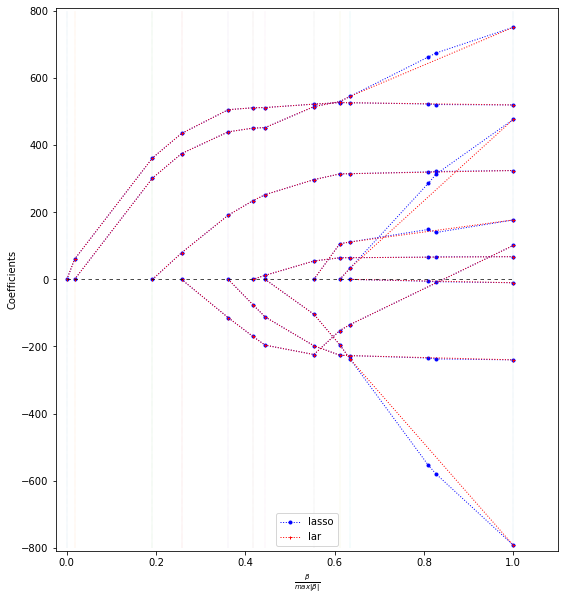

In [9]:
x_lar = np.sum(np.abs(beta_path_lar.T), axis=1)
x_lar /= x_lar[-1]

x_lasso = np.sum(np.abs(beta_path_lasso.T), axis=1)
x_lasso /= x_lasso[-1]

column_names = prostate_cancer.meta[:-1]
plt.figure(figsize=(9, 10))
plt.xlim([-0.025, 1.1])
plt.ylim([-810, 810])
yy = np.linspace(-800, 800)
xx = np.linspace(-0.3, 9.5, len(x_lar))

for i in range(X.shape[1]):
    idx_nonzero = np.where(beta_path_lasso[i, :] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path_lasso[i, idx_nonzero]
    s_temp = x_lasso[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'b:o', linewidth=1.0, markersize=3, label="lasso" if i == 0 else "")
    
    idx_nonzero = np.where(beta_path_lar[i, :] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path_lar[i, idx_nonzero]
    s_temp = x_lar[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'r:+', linewidth=1.0, markersize=3, label="lar" if i == 0 else "")

for s_ in x_lar:
    plt.plot(s_ * np.ones(len(yy)), yy, ':', linewidth=0.2)
    
plt.plot(x_lasso, np.zeros_like(x_lasso), color='black', linestyle=(0, (5, 5)), linewidth=0.7)
plt.xlabel(r'$\frac{\beta}{max|\beta|}$')
plt.ylabel('Coefficients')
plt.legend()
plt.show()

As we can see from the above plot, the profiles of coefficients of the `lar` and `lasso` are slightly different at larger $\frac{\beta}{max|\beta|}$.

**Note**: This implementation is tested against the `sklearn` implementation of both `lar` and `lasso` algorithms, and it produces identical results.